In [21]:
# This is code for loading the libraries needed for the assignment
import numpy as np
from casadi import *
import numpy.linalg as la
import matplotlib.pyplot as plt
import minecraftControl as mc

env = mc.constrainedCar()

%matplotlib inline

# The Car Environment

In the next problem we will use MPC on a vehicle which is not well-approximated by a linear time-invariant system. As a result, the optimization problem used in MPC is non-convex, and cannot be solved exactly. Regardless, we will see that MPC can drive the vehicle to a goal state. (Most of the time.)

Here is a simulation with random inputs.

Text(0, 0.5, 'u')

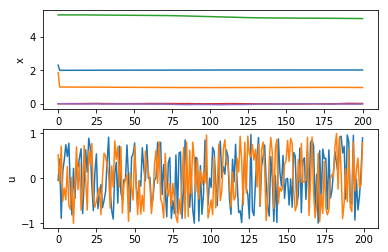

In [22]:
# We need to first call reset to initialize the state
x = env.reset()
X_traj = [x]
U_traj = []


for _ in range(200):
    # Randomly generate a feasible input
    u = env.action_space.sample()
    #u = np.array([0,.5])
    x,r,done,info = env.step(u)
    
    # Saving the state and action sequences
    X_traj.append(x)
    U_traj.append(u)
    
    # Render shows the video
    # If you don't want video, comment the line out.
    env.render()
    if done:
        # This stops the simulation when 
        # a constraint is violated
        print(info)
        print('u:',u)
        print('x:',x)
        break
    
env.close()

# Plot the trajectories
X_traj = np.array(X_traj)
U_traj = np.array(U_traj)
fig,ax = plt.subplots(2,1)
ax[0].plot(X_traj)
ax[0].set_ylabel('x')
ax[1].plot(U_traj)
ax[1].set_ylabel('u')

Here is a description of the dynamics, the constraints, and the costs used for MPC.

In [23]:

# The dynamics are defined below 


# We'll just define it using CasADi symbolics
gain = env.gain
dt = env.dt

x = MX.sym('x',5)
px = x[0]
py = x[1]
theta = x[2]
v = x[3]
omega = x[4]


u = MX.sym('u',2)
uF = u[0]
uTau = u[1]

x_dot = vertcat(v*cos(theta),
                v*sin(theta),
                omega,
                gain * uF,
                gain * uTau)

# This is the description of the dynamics
x_next = x + dt * x_dot

# This creates a callable function that can implement the dynamics
# It will return a CasADi vector,
dynamics = Function('dynamics',[x,u],[x_next])

# Here is the step loss
# Note that it only depends on the state, and does not depend 
loss =  1* px**2 + 1 * py**2 + 2 * v**2 + .1 * omega**2
step_loss = Function('step_loss',[x,u],[loss])


# No final cost
final_cost = Function('final_cost',[x],[0. ])
c = np.inf

# The constraints
tighten = 1e-3
step_constraint = Function('step_constraint',[x,u],[vertcat(x,u)])
step_lb = np.hstack([env.observation_space.low+tighten,env.action_space.low+tighten])
step_ub = np.hstack([env.observation_space.high-tighten,env.action_space.high-tighten])



# Question

Simulate the vehicle using an MPC controller. If you have it working, it should drive the vehicle to the center.
A horizon of $N=50$ should give reasonable behavior. Experiment with changing the step loss and the horizon to improve the behavior.



In [24]:
# Build your simulation here.
import mpc

In [25]:
    
N = 50

mpc_controller = mpc.buildMPCController(5,2,N,dynamics,
                                step_constraint,step_lb,step_ub,
                                step_loss,final_cost,c)



Text(0, 0.5, 'u')

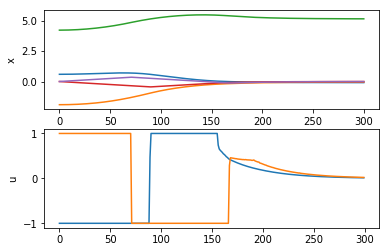

In [26]:
# Simulate and Plot
x = env.reset()
X_traj = [x]
U_traj = []
total_steps = 300

for _ in range(total_steps):
    # Randomly Generate an input
    
    u = mpc_controller(x)
    if u is None:
        print('MPC control unsuccessful')
        break
    x,r,done,info = env.step(u)
    
    # Saving the state and action sequences
    X_traj.append(x)
    U_traj.append(u)
    
    # Render shows the video
    # If you don't want to render, comment the line out.
    env.render()
    if done:
        # This stops the simulation when 
        # a constraint is violated
        print(info)
        print('u:',u)
        print('x:',x)
        break
    
env.close()

# Plot the trajectories
X_traj = np.array(X_traj)
U_traj = np.array(U_traj)
fig,ax = plt.subplots(2,1)
ax[0].plot(X_traj)
ax[0].set_ylabel('x')
ax[1].plot(U_traj)
ax[1].set_ylabel('u')

# Noisy Ball

Recall the ball environment from last homework. Recall that the dynamics had the form

$$x(k+1) = Ax(k) + Bu(k)$$

where $A$ and $B$ are given as below.

In [27]:
env = mc.constrainedBall()
dt = env.dt
A = np.array([[1,0,3 *dt,0],
              [0,1,0,3 * dt],
              [0,0,1,0],
              [0,0,0,1]])

B = np.array([[0,0],
              [0,0],
              [dt,0],
              [0,dt]])

In [28]:
# Define your solution here
Q = np.eye(4)
R = np.eye(2)
S = la.solve_discrete_are(A, B, Q, R)
K = -la.inv(R + B.T @ S @ B) @ B.T @ S @ A
# Change these to the correct values
print(S)
print(K)

AttributeError: module 'numpy.linalg' has no attribute 'solve_discrete_are'

In [39]:
G = np.eye(4)
H = np.eye(2)@K
Ak = A + B@K
AkN = la.matrix_power(Ak, 15)@B 
n_alpha = 15
alpha = la.norm(AkN, np.inf)
c = 4.62

# theta_N for each state and control input constraint
def theta_nx(n_a):
    theta = np.empty(4)
    for i in range(4):
        for k in range(n_alpha):
            temp = la.matrix_power(Ak, k)@B
            theta[i] = theta[i] + 0.1 * la.norm(G[i,:]@temp, 1)
    return theta

def theta_nu(na):
    theta = np.empty(2)
    for i in range(2):
        for k in range(n_alpha):
            temp = la.matrix_power(Ak, k)@B
            theta[i] = theta[i] + 0.1 * la.norm(H[i,:]@temp, 1)
    return theta      

N = 50
def dynamics(x,u):
    return A@x + B@u

def step_constraint(x,u):
    return vertcat(x,u)

tighten = 1e-1
eps_x = tighten * np.absolute(env.observation_space.low)
eps_u = tighten * np.absolute(env.action_space.low)
step_lb = np.hstack([env.observation_space.low + theta_nx(n_alpha)/(1-alpha), 
                     env.action_space.low + theta_nu(n_alpha)/(1-alpha)])
step_ub = np.hstack([env.observation_space.high - theta_nx(n_alpha)/(1-alpha),
                     env.action_space.high - theta_nu(n_alpha)/(1-alpha)])

def step_loss(x,u):
    return x.T @ Q @ x + u.T @ R @ u 

def final_cost(x):
    return x.T @ S @ x


mpc_nominal = mpc.buildMPCController(4,2,N,dynamics,
                                step_constraint,step_lb,step_ub,
                                step_loss,final_cost,c)

# Question 

Say instead that the dynamics are given by

$$x(k+1) = A x(k) + B(u(k) + d(k)),$$

where $d(k)$ random forces with components generated uniformly over $[-0.1,0.1]$. 

* Modify your simulation to include the input disturbances, $d(k)$. 
* Modify your MPC controller to ensure that state remains feasible.

Text(0.5, 0.98, 'Nominal trajectory and control input')

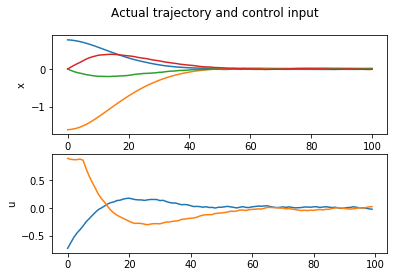

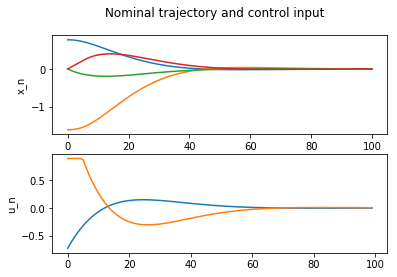

In [41]:
# Make your new controller and simulation here.
# simulation    
T_max = 100
x = env.reset()
x_n = x
X_traj = [x]
U_traj = []
XN_traj = [x_n]
UN_traj = []

for i in range(T_max):
        # compute the nominal control input
        u_n = mpc_nominal(x_n)
        # the actual control input for the ball
        u = u_n + K@(x-x_n)
        # random disturbance
        d = np.random.uniform(-0.1,0.1,2)
        # compute the nominal traj of the ball
        x_n = A@x_n + B@u_n
        # the actual traj
        u_a = u+d  # disturbed input      
        x,r,done,info = env.step(u_a)
        
        X_traj.append(x)
        U_traj.append(u)
        XN_traj.append(x_n)
        UN_traj.append(u_n)
        
        env.render()

        if done:
            # This stops the simulation when 
            # a constraint is violated
            print(info)
            print('u:',u)
            print('x:',x)
            print('K:',K)
            break

env.close()

# Plot the trajectories
X_traj = np.array(X_traj)
U_traj = np.array(U_traj)
fig,(ax1, ax2) = plt.subplots(2,1)
ax1.plot(X_traj)
ax1.set_ylabel('x')
ax2.plot(U_traj)
ax2.set_ylabel('u')
fig.suptitle('Actual trajectory and control input')

XN_traj = np.array(XN_traj)
UN_traj = np.array(UN_traj)
fig2,(ax1, ax2) = plt.subplots(2,1)
ax1.plot(XN_traj)
ax1.set_ylabel('x_n')
ax2.plot(UN_traj)
ax2.set_ylabel('u_n')
fig2.suptitle('Nominal trajectory and control input')